In [1]:
TRAIN_SIZE = 320  #544
CROP = 320   #512f

from torchvision.transforms import functional as TF
from torchvision.transforms import InterpolationMode as IM
import torch, numpy as np
from PIL import Image

# Use the same sizes you used for val/test
INF_SIZE = TRAIN_SIZE   # e.g., 320
INF_CROP = CROP         # e.g., 288

def inference_transform(pil_img):
    # resize, optional center-crop, to tensor, normalize
    img = pil_img.convert("RGB")
    img = TF.resize(img, INF_SIZE, interpolation=IM.BILINEAR)
    if INF_CROP and INF_CROP < INF_SIZE:
        img = TF.center_crop(img, INF_CROP)
    img = TF.to_tensor(img)
    img = TF.normalize(img, mean=[0.485, 0.456, 0.406],
                           std=[0.229, 0.224, 0.225])
    return img


In [2]:
import torch
import numpy as np
from PIL import Image
import os

# >>>> EDIT THESE to match CoralScapes label IDs <<<<
# Example placeholders:
#  - 0: background/water
#  - 1: healthy coral
#  - 2: bleached/diseased coral
#  - 3: algae
#  - 4: sand/rubble
# Total reef pixels (benthos on the reef, incl. coral states, algae-overgrown, rubble, sponges/anemones)
coral_ids = {
    3, 4, 6, 10, 16, 17, 18, 19, 20, 21, 22, 23,
    25, 27, 28, 29, 30, 31, 32, 33, 34, 36, 37
}

# Healthy (live coral only)
healthy_ids = {
    6, 17, 21, 22, 25, 27, 28, 31, 34, 36
}

# # Optional: a simple color map for visualization (extend as needed)
# PALETTE = {
#     0: (0, 0, 0),        # background - black
#     1: (0, 200, 0),      # healthy coral - green
#     2: (255, 255, 0),    # unhealthy coral - yellow
#     3: (0, 0, 255),      # algae - blue
#     4: (200, 150, 100),  # sand - tan
# }

@torch.no_grad()
def predict_image(
    image_input,                      # path or PIL.Image
    model,
    num_classes,
    save_mask_path=None,
    save_overlay_path=None,
):
    # Load image
    if isinstance(image_input, (str, bytes, os.PathLike)):
        pil = Image.open(image_input)
    elif isinstance(image_input, Image.Image):
        pil = image_input
    else:
        # try array-like
        pil = Image.fromarray(np.asarray(image_input))

    # Transform & run model
    img_t = inference_transform(pil).unsqueeze(0).to("cpu")  # device, [1,3,H,W]
    model.eval()
    logits = model(img_t)["out"]                  # [1,C,H,W]
    pred   = logits.argmax(1).squeeze(0).cpu().numpy().astype(np.uint8)  # [H,W]

    # Material composition (by class ID)
    counts = np.bincount(pred.ravel(), minlength=num_classes)
    total_pixels = pred.size
    composition = {cls: (int(counts[cls]), counts[cls] / max(1, total_pixels))
                   for cls in range(num_classes) if counts[cls] > 0}

    # Health score: healthy coral / all coral
    coral_count   = int(sum(counts[c] for c in coral_ids if c < len(counts)))
    healthy_count = int(sum(counts[c] for c in healthy_ids if c < len(counts)))
    health_score = (healthy_count / coral_count) if coral_count > 0 else None

    # Optional: save raw mask
    if save_mask_path is not None:
        Image.fromarray(pred, mode="L").save(save_mask_path)

    # # Optional: save overlay visualization
    # if save_overlay_path is not None:
    #     # colorize prediction
    #     color = np.zeros((*pred.shape, 3), dtype=np.uint8)
    #     for k, rgb in PALETTE.items():
    #         color[pred == k] = rgb
    #     color_img = Image.fromarray(color, mode="RGB")

    #     # resize original to match transf output dims for overlay
    #     base = pil.convert("RGB")
    #     base = base.resize(color_img.size, resample=Image.BILINEAR)

    #     # simple overlay (blend)
    #     overlay = Image.blend(base, color_img, alpha=0.45)
    #     overlay.save(save_overlay_path)

    return {
        "health_score": health_score,
        "coral_pixels": coral_count,
        "healthy_coral_pixels": healthy_count,
        "composition": composition,  # {class_id: (count, fraction_of_image)}
        "pred_mask": pred,           # numpy array [H,W]
    }


In [6]:
from datasets import load_from_disk
import random

handydandy = load_from_disk(r"C:\Users\anair26\OneDrive - Eastside Preparatory School\coral-data\coralscapesdata")


rand_df_num = random.randint(0, len(handydandy["test"]) - 1)
row = handydandy["test"][rand_df_num]
image_used = row["image"]
mask_val = row['label']


In [27]:
from torchvision import models
import matplotlib.pyplot as plt
import numpy as np

model = models.segmentation.deeplabv3_resnet50(num_classes=40)
save_path = r"C:\Users\anair26\OneDrive - Eastside Preparatory School\coral-data\model_save\deeplabv3_resnet50_coral.pth"
ckpt = torch.load(save_path, map_location="cpu")
model.load_state_dict(ckpt["model"])


res = predict_image(
    image_used,
    model=model,
    num_classes=40,
    save_mask_path="pred_mask.png",
    save_overlay_path="pred_overlay.png",
)

def health_score_processing(res):
    return float(round(res*100,2))


health_score_processed = health_score_processing(res['health_score'])


from coralscapes_labels import CORALSCAPES_LABELS

def pretty_print_composition(comp_dict):
    print(f"{'Class (ID)':<40} | {'Pixels':>10} | {'% of image':>10}")
    print("-" * 66)
    for cls, (count, frac) in sorted(comp_dict.items(), key=lambda x: -x[1][1]):  # sort by fraction desc
        frac_val = float(frac) * 100
        label = CORALSCAPES_LABELS.get(cls, f"Unknown ({cls})")
        print(f"{label} ({cls})".ljust(40), f"| {count:>10,} | {frac_val:>9.2f}%")

pretty_print_composition(res["composition"])
print(" ")
print("Health score:", health_score_processed)


Class (ID)                               |     Pixels | % of image
------------------------------------------------------------------
Background (0)                           |     69,042 |     33.71%
Turf Algae (10)                          |     54,348 |     26.54%
Rubble (13)                              |     26,398 |     12.89%
Sponges (12)                             |     18,563 |      9.06%
Sand (14)                                |     16,670 |      8.14%
Water Column (17)                        |      7,336 |      3.58%
Dead Coral (6)                           |      3,896 |      1.90%
Shadow (18)                              |      3,364 |      1.64%
Macroalgae (9)                           |      2,112 |      1.03%
Bleached Rock (31)                       |      2,041 |      1.00%
Bleached Silt (36)                       |        805 |      0.39%
Coral (Other) (20)                       |        154 |      0.08%
Crustose Coralline Algae (8)             |         36 |      0

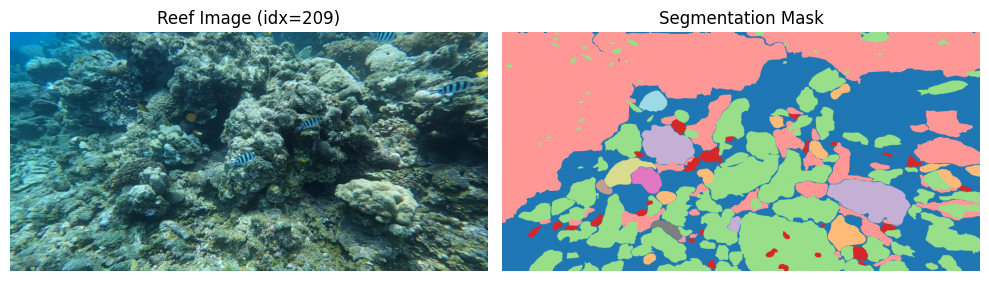

In [9]:
plt.figure(figsize=(10,4))
plt.subplot(1, 2, 1)
plt.imshow(image_used)
plt.title(f"Reef Image (idx={rand_df_num})")
plt.axis("off")

plt.subplot(1, 2, 2)
plt.imshow(mask_val, cmap="tab20")   # int-coded classes → colored for visualization
plt.title("Segmentation Mask")
plt.axis("off")
plt.tight_layout()
plt.show()

In [28]:
import numpy as np
from PIL import Image


ignore_index = None    # set to 255 if your masks use 255 as ignore

def compute_composition_and_health(mask, coral_ids=coral_ids,
                                   healthy_ids=healthy_ids, ignore_index=ignore_index):
    """
    mask: PIL.Image (L) or numpy array HxW of integer class IDs
    num_classes: total classes in dataset (e.g., 40)
    coral_ids: set of class IDs considered 'coral'
    healthy_ids: subset of coral_ids considered 'healthy'
    ignore_index: value to exclude (e.g., 255) or None
    """
    # Normalize input to numpy int array
    if isinstance(mask, Image.Image):
        mask = np.array(mask)
    else:
        mask = np.asarray(mask)
    mask = mask.astype(np.int64)

    # Optional: drop ignore pixels
    if ignore_index is not None:
        valid = (mask != ignore_index)
        flat = mask[valid].ravel()
    else:
        flat = mask.ravel()

    # Safety: if nothing valid, return empty composition and None health
    total_pixels = int(flat.size)
    if total_pixels == 0:
        return {}, None

    # Count pixels per class across the *dataset's full class space*
    counts = np.bincount(flat, minlength=40)

    # Build composition in the SAME raw format you used before
    composition = {
        cls: (int(counts[cls]), counts[cls] / max(1, total_pixels))
        for cls in range(40)
        if counts[cls] > 0
    }

    # Health score = healthy coral / all coral (None if no coral present)
    coral_count   = int(sum(counts[c] for c in coral_ids   if c < len(counts)))
    healthy_count = int(sum(counts[c] for c in healthy_ids if c < len(counts)))
    health_score = (healthy_count / coral_count) if coral_count > 0 else None

    return composition, health_score

comp,health = compute_composition_and_health(mask_val)
print(pretty_print_composition(comp))
print(health_score_processing(health))


Class (ID)                               |     Pixels | % of image
------------------------------------------------------------------
Background (0)                           |    629,031 |     29.99%
Rubble (13)                              |    594,319 |     28.34%
Turf Algae (10)                          |    499,789 |     23.83%
Sand (14)                                |    146,840 |      7.00%
Water Column (17)                        |     75,258 |      3.59%
Dead Coral (6)                           |     42,267 |      2.02%
Macroalgae (9)                           |     37,526 |      1.79%
Sponges (12)                             |     33,079 |      1.58%
Bleached Rock (31)                       |     13,310 |      0.63%
Bleached Acropora (23)                   |     10,144 |      0.48%
Bleached Silt (36)                       |      7,768 |      0.37%
Bleached Soft Coral (26)                 |      5,094 |      0.24%
Coral (Other) (20)                       |      2,727 |      0